In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.keras import Input, Model
from sklearn.model_selection import train_test_split

In [2]:
#define the noisy dataset
#x is unnormalized image dataset
def add_noise(x):
    
    x_noise = x/255 + np.random.rand(x.shape[0], x.shape[1], x.shape[2]) * np.random.normal(loc=0.5, scale=0.3, size=x.shape)
    x_noise = np.clip(x_noise, 0.0, 1.)
    
    return x_noise

#Scale the image and reshape it to the shape
#provide custom_shape for different shape. Default shape is x.shape[0], x.shape[1], x.shape[2], 1 
def scale_reshape_clip(x, custom_shape=False, min_val=0.0, max_val=1.0):
    
    shape = (x.shape[0], x.shape[1], x.shape[2], 1)
    if custom_shape:
        shape = custom_shape
        
    x = np.reshape(x/255, shape)
    x = np.clip(x, min_val, max_val)
    
    return x

#images: list of images to be plotted
def plot(images, figsize=(10, 10)):

    plt.figure(figsize=figsize)
    
    for index, image in enumerate(images):
        # display original
        ax = plt.subplot(2, len(images), index + 1)
        plt.imshow(image.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

#Make a prediction on the model given a single image
def predict(model, img):
    
    #Get image with shape (28, 28, 1) and convert it to (1, 28, 28, 1)
    img = np.reshape(img, (1, img.shape[0], img.shape[1], 1))
    
    #make prediction
    pred = model.predict(img)
    
    #return prediction image with shape (28, 28)
    pred = np.reshape(pred, (pred.shape[1], pred.shape[2]))
    
    return pred

#A non-trainable model to blur the images
def zoom():
    
    input_img = Input(shape=(28, 28, 1), dtype='float32')
    
    x = MaxPooling2D((2, 2))(input_img)
    x = UpSampling2D((2, 2))(x)
    
    model = Model(input_img, x)
    return model


#Blur images to add more images to the dataset
#x: list of images to be blured, start, end: start and ending index of the list
def blur_images(x, start, end):

    org = x[start:end]
    blur = []
    for index, img in enumerate(org):
        blur.append(predict(zoom_model, img))
    
    return np.array(blur), np.array(org)

In [3]:
opt = tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
loss = 'binary_crossentropy'

In [4]:
zoom_model = zoom()
zoom_model.compile(loss=loss, optimizer=opt, metrics=['accuracy', 'binary_accuracy'])

In [5]:
#load the dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [6]:
blurred, original = blur_images(x_train, 2000, 6000)

#Reshape the blurred images to a 3 dim image
blurred = np.reshape(blurred/255, (blurred.shape[0], blurred.shape[1], blurred.shape[2], 1))
original = np.reshape(original/255, (original.shape[0], original.shape[1], original.shape[2], 1))

zoom


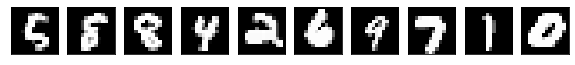

actual


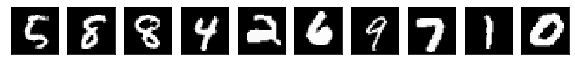

In [7]:
print("zoom")
plot(blurred[:10])
print("actual")
plot(original[:10])

In [9]:
#Define the noisy dataset which will be input to the model
x_train_noise, x_test_noise = scale_reshape_clip(add_noise(x_train)), scale_reshape_clip(add_noise(x_test))

#Reshape and scale the output dataset
x_train, x_test = scale_reshape_clip(x_train), scale_reshape_clip(x_test)

In [10]:
#Split the test set in test and dev set
x_test_noise, x_dev_noise, x_test, x_dev = train_test_split(x_test_noise, x_test, test_size=0.1)

In [11]:
#add some noiseless data to the training set
x_train_noise = np.concatenate((x_train_noise, x_test[:2000], blurred))
x_train = np.concatenate((x_train, x_test[:2000], original))

x_test = np.concatenate((x_test[2000:], blurred[:2000]))
x_test_noise = np.concatenate((x_test_noise[2000:], original[:2000]))

53289


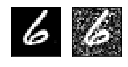

64349


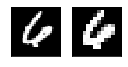

In [14]:
#Visualize results:
for i in range(2):
    index = np.random.randint(50000, len(x_train))
    ip_img, op_img = x_train[index], x_train_noise[index]
    print(index)
    plot([ip_img, op_img], figsize=(2, 2))

In [13]:
x_train.shape, x_train_noise.shape, x_test.shape, x_test_noise.shape, x_dev.shape, x_dev_noise.shape

((66000, 28, 28, 1),
 (66000, 28, 28, 1),
 (9000, 28, 28, 1),
 (9000, 28, 28, 1),
 (1000, 28, 28, 1),
 (1000, 28, 28, 1))

In [15]:
def model():
    
    input_img = Input(shape=(28, 28, 1), dtype='float32')
    
    #1st Convolution Layer with Batch Normalization
    x = Conv2D(64, (9, 9), activation='sigmoid')(input_img)
    x = BatchNormalization()(x)
    
    #2nd Convolution Layer with Batch Normalization
    x = Conv2D(32, (1, 1), activation='sigmoid')(x)
    
    #1st DeConv Layer
    x = Conv2DTranspose(16, (5, 5), activation='sigmoid')(x)
    
    #2nd DeConv layer
    x = Conv2DTranspose(1, (5, 5), activation='sigmoid')(x)
    
    model = Model(input_img, x)
    
    return model
    

In [16]:
auto_encode = model()

In [17]:
auto_encode.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 64)        5248      
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 20, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        2080      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 24, 24, 16)        12816     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         401       
Total params: 20,801
Trainable params: 20,673
Non-trainable params: 128
_____________________________________________________

In [18]:
auto_encode.compile(loss=loss, optimizer=opt, metrics=['accuracy', 'binary_accuracy'])

In [19]:
history = auto_encode.fit(x_train_noise, x_train, epochs=5, batch_size=64, validation_data=(x_test_noise, x_test), shuffle=True)

Train on 66000 samples, validate on 9000 samples
Epoch 1/5
66000/66000 [==============================] - 220s 3ms/sample - loss: 0.1321 - accuracy: 0.8107 - binary_accuracy: 0.8107 - val_loss: 0.1473 - val_accuracy: 0.8008 - val_binary_accuracy: 0.8008
Epoch 2/5
66000/66000 [==============================] - 213s 3ms/sample - loss: 0.0824 - accuracy: 0.8147 - binary_accuracy: 0.8147 - val_loss: 0.1555 - val_accuracy: 0.8007 - val_binary_accuracy: 0.8007
Epoch 3/5
66000/66000 [==============================] - 214s 3ms/sample - loss: 0.0783 - accuracy: 0.8148 - binary_accuracy: 0.8148 - val_loss: 0.1616 - val_accuracy: 0.8006 - val_binary_accuracy: 0.8006
Epoch 4/5
66000/66000 [==============================] - 215s 3ms/sample - loss: 0.0756 - accuracy: 0.8149 - binary_accuracy: 0.8149 - val_loss: 0.1373 - val_accuracy: 0.8011 - val_binary_accuracy: 0.8011
Epoch 5/5
66000/66000 [==============================] - 214s 3ms/sample - loss: 0.0748 - accuracy: 0.8150 - binary_accuracy: 0.815

 Noisy Image  Predicted Image  Actual Image
791


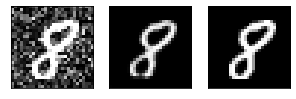

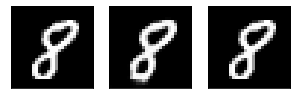

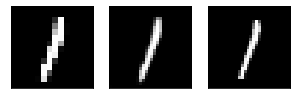

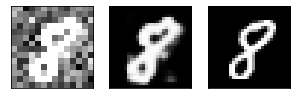

293


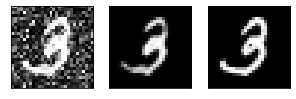

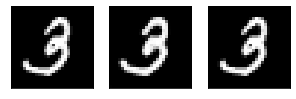

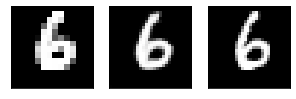

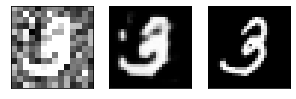

235


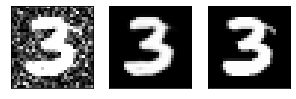

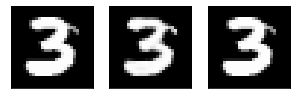

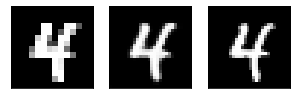

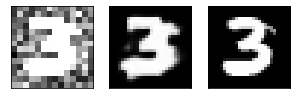

793


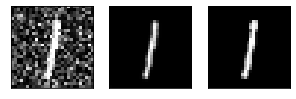

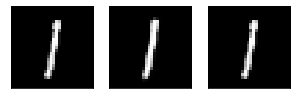

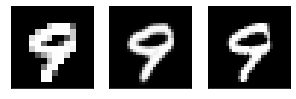

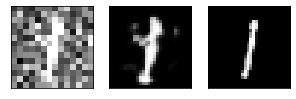

968


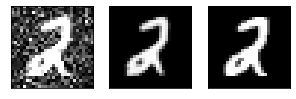

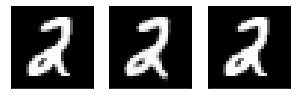

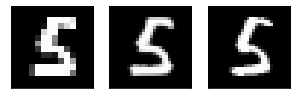

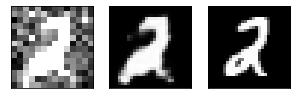

In [37]:
print(" Noisy Image  Predicted Image  Actual Image")
for i in range(5):
    
    #Select an image from development set
    index = np.random.randint(0, len(x_dev))
    print(index)
    img_noise = x_dev_noise[index]
    img_org = x_dev[index]
    img_blur = blurred[index]
    
    #Make a prediction on noisy, original and a blurred image
    pred_noise = predict(auto_encode, img_noise)
    pred_org = predict(auto_encode, img_org)
    pred_blur = predict(auto_encode, img_blur)
    pred_noisy_blur = predict(auto_encode, predict(zoom_model, img_noise))
    
    plot([img_noise*255, pred_noise*255, img_org*255], figsize=(5, 5))
    plot([img_org*255, pred_org*255, img_org*255], figsize=(5, 5))
    plot([img_blur*255, pred_blur*255, original[index]], figsize=(5, 5))
    plot([predict(zoom_model, img_noise)*255, pred_noisy_blur*255, img_org*255], figsize=(5, 5))

In [38]:
#Save the model
auto_encode.save('mnist_auto_encoder_with_zoomed_images.h5')

In [39]:
model = auto_encode.load_weights('mnist_auto_encoder.h5')

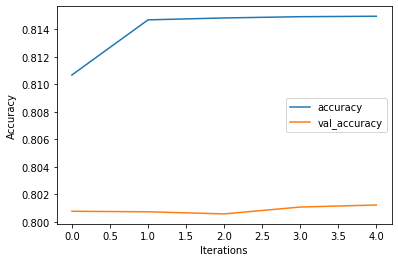

In [40]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

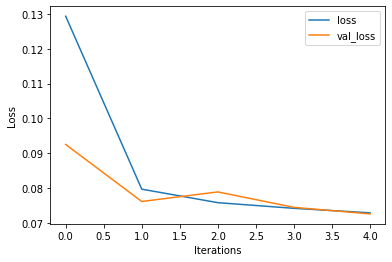

In [158]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()